# CycleGAN implemented in Keras

![alt text](https://junyanz.github.io/CycleGAN/images/cyclegan_blogs.jpg)

## Mount google drive

In [0]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/sirius/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Imports

In [0]:
import numpy as np
import os
import tarfile
import urllib
from keras.preprocessing import image as kimage
import keras
from keras.models import Sequential, Model
from keras.layers import *
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from PIL import Image
from keras.optimizers import Adam

Using TensorFlow backend.


## Disable warnings

In [0]:
import warnings
warnings.filterwarnings('ignore')

## Load dataset

### Download data and unpack it if necessary

In [0]:
import shutil
import random

BATCH_SIZE = 2
folder_name = 'horse2zebra/'
x_name = 'trainA'
y_name = 'trainB'

x_PATH = folder_name + 'train/A/'
y_PATH = folder_name + 'train/B/'

if 'horse2zebra' not in os.listdir():
  # this two commands run whole fucking life
  !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip
  !unzip horse2zebra.zip
  os.mkdir(folder_name + 'train')
  os.mkdir(folder_name + 'train/' + 'A/')
  os.mkdir(folder_name + 'train/' + 'B/')
  shutil.move(folder_name + x_name, x_PATH)
  shutil.move(folder_name + y_name, y_PATH)
  !rm -rf horse2zebra.zip
  '''Make len(X) % batch size == 0'''
  for i in range(len(os.listdir(x_PATH + '/trainA')) % BATCH_SIZE):
    fname = x_PATH + '/trainA/' + random.choice(os.listdir(x_PATH + '/trainA'))
    os.remove(fname)

  for i in range(len(os.listdir(y_PATH + '/trainB')) % BATCH_SIZE):
    fname = y_PATH + '/trainB/' + random.choice(os.listdir(y_PATH + '/trainB'))
    os.remove(fname)

print(len(os.listdir(y_PATH + '/trainB')) % BATCH_SIZE)
print(len(os.listdir(y_PATH + '/trainB')) % BATCH_SIZE)

0
0


### Create dataflow

In [0]:
IMAGE_SHAPE = (256, 256, 3)
HALF_IMAGE_SHAPE = (256, 128, 3)
HALF_BATCH_SIZE = BATCH_SIZE // 2

datagen = keras.preprocessing.image.ImageDataGenerator(
  rescale=1.0/255,
)

# Generator which yields train batches
x_generator = datagen.flow_from_directory(
    directory=x_PATH,
    target_size=IMAGE_SHAPE[:2],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

y_generator = datagen.flow_from_directory(
    directory=y_PATH,
    target_size=IMAGE_SHAPE[:2],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True,
    seed=42
)

class BatchWithCache(object):
  '''This class is for training discriminator'''
  def __init__(self, batch_size, batch_generator, image_generator):
    self.batch_size = batch_size
    self.hb = batch_size // 2
    self.cache = np.empty((self.hb,) + IMAGE_SHAPE)
    self.bg = batch_generator
    self.ig = image_generator
    
  def get(self):
      '''returns fake images with labels'''
      batch = np.empty((self.batch_size,) + IMAGE_SHAPE)
      samples = next(self.bg)[0]
      generated = self.ig.predict(samples)
      if self.cache.size != 0:  # there is cache
        batch[:self.hb] = self.cache[:]
        batch[self.hb:] = generated[:self.hb]
        self.cache = generated[self.hb:]
      else:
        batch = generated[:]
        cache = generated[self.hb:]
      
      assert batch.shape[0] == self.batch_size
      return (batch[:, :, :, :], np.zeros((self.batch_size,)))

Found 1064 images belonging to 1 classes.
Found 1328 images belonging to 1 classes.


## Unet creator

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add


def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True, name="Generator", o_name="Generator_output"):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid', name=o_name) (c9)
    model = Model(inputs=[input_img], outputs=[outputs], name=name)
    return model

## Helper functions

In [0]:
def noisy(images):
  '''add noise to each picture in array'''
  imgs = np.copy(images)
  for i in range(len(imgs)):
    image = imgs[i]
    row,col,ch= image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    imgs[i] = image + gauss
  return imgs

def on(name):
  '''get output layer name'''
  return name + "_output"

def inn(name):
  '''get input layer name'''
  return name + "_input"

def sb(x):
  '''scale image back to normal condition'''
  return x * 255

def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width, 3))
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img.astype('uint8')
  
def plot_img(i, save_name=None):
  plt.imshow(i)
  plt.show()
  if save_name is not None:
    img = Image.fromarray(i)
    img.save(save_name)
    
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

## Main cycle gan class which makes all the fun

In [0]:
class CycleGAN(object):
  '''
  X is X
  Y is Y
  '''
  
  Gxy_NAME = 'Generator_xy'
  Gyx_NAME = 'Generator_yx'
  
  Dx_NAME = 'Discriminator_x'
  Dy_NAME = 'Discriminator_y'  


  def __init__(
      self, x_generator, y_generator
  ):
    self.plot_iter = 5
    
    self.x_generator, self.y_generator = x_generator, y_generator

    '''object to control training history'''
    self.histories = {
        'GxyGyx': [],
        'GyxGxy': [],
        'GxyDy' : [],
        'GyxDx': [],
        'Dy': [],
        'Dx': [],
    }
    
    self.optimizer = Adam(0.0002, 0.5)

    y_input = Input(IMAGE_SHAPE, name='y_input')
    
    '''these models are only trained in bundle'''
    self.Gxy = self.create_generator(
      in_name=inn(self.Gxy_NAME), o_name=on(self.Gxy_NAME), name=self.Gxy_NAME
    )
    self.Gyx = self.create_generator(
      in_name=inn(self.Gyx_NAME), o_name=on(self.Gyx_NAME), name=self.Gyx_NAME
    )
    '''six models necessary for training'''
    '''two models to train discriminators on fake and real images'''
    self.Dx = self.create_discriminator(
      in_name=inn(self.Dx_NAME), o_name=on(self.Dx_NAME), name=self.Dx_NAME, dropout_r=0.0
    )
    self.Dy = self.create_discriminator(
      in_name=inn(self.Dy_NAME), o_name=on(self.Dy_NAME), name=self.Dy_NAME, dropout_r=0.0
    )

    '''two models to train generators using remodeling'''
    Gxy_input1 = Input(IMAGE_SHAPE, name='x_input')
    Gxy_output1 = self.Gxy(Gxy_input1)
    Gyx_output1 = self.Gyx(Gxy_output1)
    self.GxyGyx = Model(Gxy_input1, Gyx_output1)  # x -> Gxy -> y -> Gyx -> x
    self.GxyGyx.compile(
      loss='mae', optimizer=self.optimizer
    )
    
    Gyx_input1 = Input(IMAGE_SHAPE, name='y_input')
    Gyx_output1 = self.Gyx(Gyx_input1)
    Gxy_output1 = self.Gxy(Gyx_output1)
    self.GyxGxy = Model(Gyx_input1, Gxy_output1)  # y -> Gyx -> x -> Gxy -> y
    self.GyxGxy.compile(
      loss='mae', optimizer=self.optimizer
    )

    '''two models to train generators using discriminator'''
    self.Dy.trainable = False
    Gxy_input2 = Input(IMAGE_SHAPE, name='x_input')
    Gxy_output2 = self.Gxy(Gxy_input2)
    Dy_output = self.Dy(Gxy_output2)
    self.GxyDy = Model(Gxy_input2, Dy_output) # x -> Gxy -> y -> Dy -> [0, 1]
    self.GxyDy.compile(
      loss='mse', optimizer=self.optimizer
    )
    self.Dx.trainable = False
    Gyx_input2 = Input(IMAGE_SHAPE, name='y_input')
    Gyx_output2 = self.Gyx(Gyx_input2)
    Dx_output = self.Dx(Gyx_output2)
    self.GyxDx = Model(Gyx_input2, Dx_output)  # y -> Gyx -> x -> Dx -> [0, 1]
    self.GyxDx.compile(
      loss='mse', optimizer=self.optimizer
    )
    
    '''generators of fake images'''
    self.fake_Y_generator = BatchWithCache(
      BATCH_SIZE, self.x_generator, self.Gxy
    )

    self.fake_X_generator = BatchWithCache(
      BATCH_SIZE, self.y_generator, self.Gyx
    )


  def create_generator(self, in_name='Generator input', name='Generator', o_name='Generator output'):
    inp = Input(IMAGE_SHAPE, name=in_name)
    gen = get_unet(inp, name=name, o_name=o_name)
    gen.compile(
      loss='mae', optimizer=self.optimizer
    )
    return gen


  def create_discriminator(
      self, name="Discriminator", 
      o_name="Discriminator_output", 
      in_name='Discriminator_input',
      dropout_r=0.5):
    inp = Input(IMAGE_SHAPE, name=in_name)
    c1_b1 = Conv2D(512, kernel_size=3, padding='same')(inp)
    c2_b1 = Conv2D(256, kernel_size=3, padding='same')(c1_b1)
    mp_b1 = MaxPooling2D()(c2_b1)
    d_b1 = Dropout(dropout_r)(mp_b1)
    
    c1_b2 = Conv2D(128, kernel_size=3, padding='same')(d_b1)
    c2_b2 = Conv2D(64, kernel_size=3, padding='same')(c1_b2)
    mp_b2 = MaxPooling2D()(c2_b2)
    d_b2 = Dropout(dropout_r)(mp_b2)
    
    c1_b3 = Conv2D(32, kernel_size=3, padding='same')(d_b2)
    c2_b3 = Conv2D(16, kernel_size=3, padding='same')(c1_b3)
    mp_b3 = MaxPooling2D()(c2_b3)
    d_b3 = Dropout(dropout_r)(mp_b3)
    
    f = Flatten()(d_b3)
    d1 = Dense(512)(f)
    d2 = Dense(256)(d1)
    d3 = Dense(1, activation='sigmoid', name=o_name)(d2)
    disc = Model(inputs=[inp], outputs=d3, name=name)
    disc.compile(
      loss='mse', optimizer=self.optimizer,  # metrics=['acc']
    )
    return disc
  
  
  def train(self, epochs):
    for i in range(epochs):
      X = noisy(next(self.x_generator)[0])
      Y = noisy(next(self.y_generator)[0])
      fake_X = self.fake_X_generator.get()[0]
      fake_Y = self.fake_Y_generator.get()[0]
      fake = np.zeros(BATCH_SIZE)
      real = np.ones(BATCH_SIZE)
      '''first train discriminator for some epochs'''
      '''train discriminators on real images'''
      d_X = np.concatenate((X, fake_X))
      d_X_labels = np.concatenate((real, fake))
      self.histories['Dx'].append(self.Dx.train_on_batch(d_X, d_X_labels))

      d_Y = np.concatenate((Y, fake_Y))
      d_Y_labels = np.concatenate((real, fake))
      self.histories['Dy'].append(self.Dy.train_on_batch(d_Y, d_Y_labels))
      
      '''that might be optional'''
      X = noisy(next(self.x_generator)[0])
      Y = noisy(next(self.y_generator)[0])
      fake_X = self.fake_X_generator.get()[0]
      fake_Y = self.fake_Y_generator.get()[0]
        
      
      '''optimize cycle consistency losses'''
      self.histories['GxyGyx'].append(self.GxyGyx.train_on_batch(X, X))
      self.histories['GyxGxy'].append(self.GyxGxy.train_on_batch(Y, Y))
      
      '''train generators'''
      self.histories['GxyDy'].append(self.GxyDy.train_on_batch(X, real))
      self.histories['GyxDx'].append(self.GyxDx.train_on_batch(Y, real))
      
      '''show review'''
      if not (self.plot_iter % 1):
        x = X[:1]
        print("Iteration %d, x to fucking y" % i)
        initial_x = sb(x[0]).astype('uint8')
        generated_y = sb(self.Gxy.predict(x)[0]).astype('uint8')
        plot_img(concat_images(initial_x, generated_y))

In [0]:
cg = CycleGAN(x_generator, y_generator)

W0720 06:23:23.177130 140205236504448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 06:23:23.182770 140205236504448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 06:23:23.184326 140205236504448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0720 06:23:23.222899 140205236504448 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0720 06:23:23.223912

## Train model

In [0]:
cg.train(25)

## Check losses 

Loss while training GxyGyx and GyxGxy


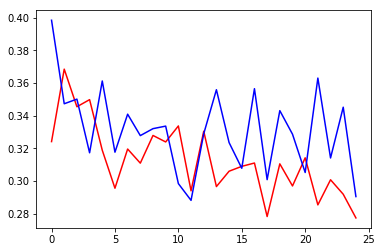

In [0]:
print("Loss while training GxyGyx and GyxGxy")
plt.plot(cg.histories['GxyGyx'], color='r');
plt.plot(cg.histories['GyxGxy'], color='b');

In [0]:
print("Loss while training GyxDx and GxyDy")
plt.plot(cg.histories['GyxDx'], color='r')
plt.plot(cg.histories['GxyDy'], color='b')

In [0]:
print("Loss while training Dx and Dy")
plt.plot(cg.histories['Dx'], color='r')
plt.plot(cg.histories['Dy'], color='b')